# Tree segmentation

We use the `<TreeSegmenter>` class to build a deep-learning based tree segmentation model.

### Warping

The nDSM model from LiDAR might not be completely aligned with the satellite. This is a common problem, hard to solve automatically and is due to bad/different ortho-recitification process. 
Here, I used Photoshop to try to match as well as possible the nDSM and satellite manually.
Use the `warping.py` script to generate a (better) aligned version.

<img src="images/nDSM_unwarped.jpeg" width="400">
<img src="images/nDSM_warped.jpeg" width="400">

### VIRASS library
Import `VIRASS` library, which will be used for the entire framework. The library implements all the sub-tasks (tree segmentation, tree species classification, risk analysis, etc.) that will be used later on. 

In [1]:
# Load the VIRASS library
import VIRASS as ges

### Generating tree mask ground-truth

We extract a tree mask ground truth of the area, namely $GT_{tree}$. 

$GT_{tree}$ is used for the training and validation of the tree segmentation model.
$GT_{tree}$ is computed as $GT_{tree} = (nDSM > Th_1) \vee (NDVI > Th_2)$ where $Th_1$ and $Th_2$ are thresholds for the NDSM and NDVI, respectively.  
nDSM comes from the previous step. NDVI is calculates from QGIS (even though Python can be used as well)

In [3]:
# Load nDSM and NDVI
nDSM, meta_data = ges.io.open_geoTiFF("_data/trees/3D_modeling/GT/warping/nDSM_warped.tif")
NDVI = ges.io.open_geoTiFF("_data/NDVI.tif", with_meta_data = False)

# Calculate the tree mask ground truth 
GT_tree_mask = ges.geo_utils.generate_tree_points(nDSM, NDVI, Th1 = 2, Th2 = 0.1)
# Export it
ges.io.export_GEOtiff(ges.utils.open_dir("Set <tree_points> saving directory ") + "/GTtree.tif", GT_tree_mask, meta_data) 

Tranposing dimensions: 

(1, 9024, 12915)
--> (9024, 12915, 1)
Tranposing dimensions: 

(1, 9023, 12914)
--> (9023, 12914, 1)
Resizing to same shape
Tranposing dimensions: 

(9023, 12914, 1)
--> (1, 9023, 12914)


We apply a morphological closing to `GT_tree_mask` to "close" the gaps and have a more continous mask

In [6]:
# Morphological closing
# Load the ground truth
GT_tree_mask, meta_data_GT = ges.io.open_geoTiFF("_data/trees/tree_segmentation/GT/GTtree.tif")
GT = ges.tree_segmentation.refine_tree_mask(GT_tree_mask, meta_data)
ges.io.export_GEOtiff("_data/trees/tree_segmentation/GT/GTtree_closed.tif", GT, meta_data)

Tranposing dimensions: 

(1, 9024, 12915)
--> (9024, 12915, 1)
Tranposing dimensions: 

(9024, 12915, 1)
--> (1, 9024, 12915)


### Import satellite image

Tranposing dimensions: 

(8, 9023, 12914)
--> (9023, 12914, 8)


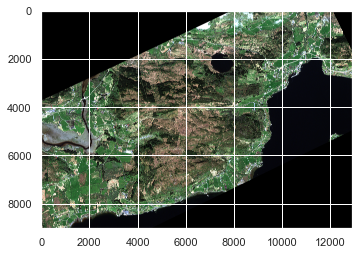

In [7]:
import matplotlib.pyplot as plt
SAT_image, meta_data = ges.io.open_geoTiFF("_data/WorldView_area.tif") 
# Visualize satellite image
plt.imshow(ges.geo_utils.multiband_to_RGB(SAT_image))

### Tree segmentation
Initialize the `TreeSegmenter` class. The behaviour of the class is controlled by the YAML config file.

In [8]:
tree_segmenter = ges.tree_segmentation.TreeSegmenter(config_file = "tree_segmenter_config.yaml")
tree_segmenter.print_attributes()


***class <TreeSegmenter> initialized ***


---Printing class attributes:---
X_map = None
y_map = None
meta_data = None
DLmodel = None
patch_radius = 0
working_dir = C:/Users/miche/Dropbox/PhD/Projects/GridEyeS/PWD_2/VIRASS/_data/trees/tree_segmentation/\
config = {'config_training': {'architecture': 'unet', 'patch_number': 20000, 'patch_radius': 40, 'model_name': 'Unet_segmenter_1_2', 'n_epochs': 200, 'lr': 0.001}}




Load the input image and the ground truth

In [9]:
tree_segmenter.load_X_map("_data/WorldView_area.tif")
tree_segmenter.load_y_map("_data/trees/tree_segmentation/GT/GTtree_closed.tif")


 Loading X_map
Tranposing dimensions: 

(8, 9023, 12914)
--> (9023, 12914, 8)
X_map shape:(9023, 12914, 8)
X_map loaded 


 Loading y_map
Tranposing dimensions: 

(1, 9024, 12915)
--> (9024, 12915, 1)
Ground truth shape:(9024, 12915, 1)
y_map loaded 



Load the model. The model name is specified in the condig file. If the model exists, the class will load it from the disk. If not, it will train a new model.

--Model loaded


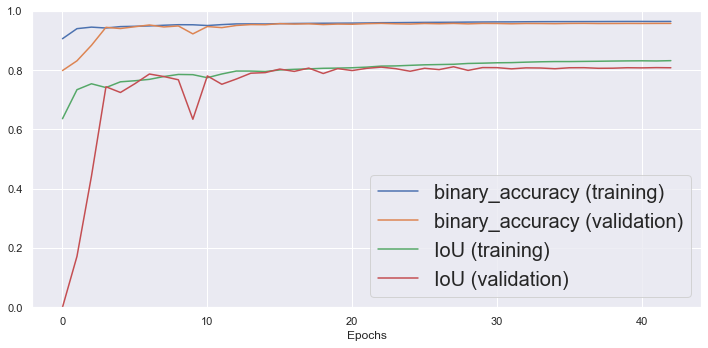

In [11]:
# Load model
tree_segmenter.build_model()
# Plot training history
tree_segmenter.plot_training_history()

[](/docs/DL_architectures/Unet_tree_segmenter.png)

<img src="docs/DL_architectures/Unet_tree_segmenter.png" width="600">

When the model is avialable, we can use it to segment trees over the whole area. If the input is tto big, it will be automatically divided into parts, and stichted them back together.

*TODO: More info about the stiching process*

In [ ]:
# Generate tree mask over the whole area
tree_map_pred = tree_segmenter.generate_tree_map(SAT_image)

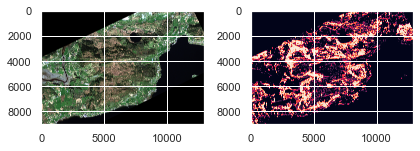

In [17]:
fig, axarr = plt.subplots(1,2)
axarr[0].imshow(ges.geo_utils.multiband_to_RGB(SAT_image))
axarr[1].imshow(tree_map_pred)
plt.tight_layout()

In case we need a binary mask, we can binarize it using a threshold.  

In [ ]:
tree_pred_bn = ges.tree_segmentation.binarize_treeMap(tree_map_pred, thresholds = [50])

and export them as geoTIFF, to visualize them in QGIS.

In [ ]:
ges.io.export_GEOtiff("_data/trees/tree_segmentation/tree_pred.tif", tree_pred_bn, meta_data)
ges.io.export_GEOtiff("_data/trees/tree_segmentation/tree_pred_bn.tif", tree_pred_bn, meta_data)